In [1]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import torch.optim as optim
from src.train import Trainer # Import trainer
from src.utils import display_stats # Import methode for display training stats
from src.preprocess import load_data # Import the data loading function
from src.model import StudentModel # Import the model class
import torch.nn.utils.prune as prune # Import prune class

## PRUNING

In [2]:
def apply_pruning(module, name = "weight" , amount = 0.3, n = 2, dim = 0, type = "struct", iter = 1):
    for i in range(iter):
        if type == "struct":
            # Appliquer un pruning L2 sur les poids des 2 premières couches de convolution
            prune.ln_structured(module.features[0], name=name, amount=amount, n=n, dim=dim) # Couche 1
            prune.ln_structured(module.features[3], name=name, amount=amount, n=n, dim=dim) # Couche 2
        else:
            # Appliquer un pruning L1 sur les poids des 2 premières couches de convolution
            prune.l1_unstructured(module=module.features[0], name=name, amount=amount)  # Couche 1
            prune.l1_unstructured(module=module.features[3], name=name, amount=amount)  # Couche 2
    prune.remove(module.features[0], name)
    prune.remove(module.features[3], name)

In [3]:
ORIGINAL_MODEL = "models/distillated_model.pth"

### Structured Pruning

In [4]:
student_m1_prune = StudentModel()
student_m1_prune.load_state_dict(torch.load(ORIGINAL_MODEL))
apply_pruning(student_m1_prune, type="struct", iter = 2)

### Unstructure Pruning

In [5]:
student_m2_prune = StudentModel()
student_m2_prune.load_state_dict(torch.load(ORIGINAL_MODEL))
apply_pruning(student_m2_prune, type="unstruct", iter=2)

In [6]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(f'Device: {device}')

# Training parameters
epochs_m1 = 50
epochs_m2 = 50
batch_size = 32
learning_rate_m1 = 1e-5
learning_rate_m2 = 1e-6
validation_split=0.1

criterion = nn.CrossEntropyLoss()
# Load the MNIST dataset
train_loader, valid_loader, test_dataloader = load_data(batch_size=batch_size, validation_split=validation_split)
student_m1_prune = student_m1_prune.to(device)
student_m2_prune = student_m2_prune.to(device)

student_m = StudentModel()
student_m.load_state_dict(torch.load(ORIGINAL_MODEL))
student_m = student_m.to(device)

Device: mps


## EVALUATE PRUNED MODELS

In [7]:
# Evaluate model performance on the entire test dataset
test_loss = 0
correct = 0
with torch.no_grad():
    student_m.eval()
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = student_m(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()   
# Compute the average loss across all test samples
test_loss /= len(test_dataloader)
# Print evaluation results
print(f'\nOriginal Model Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({100. * correct / len(test_dataloader.dataset):.0f}%)\n')

# Evaluate model performance on the entire test dataset
test_loss = 0
correct = 0
with torch.no_grad():
    student_m1_prune.eval()
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = student_m1_prune(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()   
# Compute the average loss across all test samples
test_loss /= len(test_dataloader)
# Print evaluation results
print(f'\nPruned Model 1(structured) Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({100. * correct / len(test_dataloader.dataset):.0f}%)\n')


# Evaluate model performance on the entire test dataset
test_loss = 0
correct = 0
with torch.no_grad():
    student_m2_prune.eval()
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = student_m2_prune(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()   
# Compute the average loss across all test samples
test_loss /= len(test_dataloader)
# Print evaluation results
print(f'\nPruned Model 2(unstructured) Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({100. * correct / len(test_dataloader.dataset):.0f}%)\n')


Original Model Test set: Average loss: 0.0747, Accuracy: 9756/10000 (98%)


Pruned Model 1(structured) Test set: Average loss: 0.4870, Accuracy: 8583/10000 (86%)


Pruned Model 2(unstructured) Test set: Average loss: 0.0819, Accuracy: 9754/10000 (98%)



In [8]:
# Save the trained model parameters
torch.save(student_m1_prune.state_dict(), "models/student_model_pruned_1.pth")
print("Model saved to models/student_model_pruned_1.pth")
torch.save(student_m2_prune.state_dict(), "models/student_model_pruned_2.pth")
print("Model saved to models/student_model_pruned_2.pth")

Model saved to models/student_model_pruned_1.pth
Model saved to models/student_model_pruned_2.pth


## FINE TUNE MODEL PRUNED 1

In [9]:
criterion_pruned_1 = nn.CrossEntropyLoss()
sgd_pruned_1 = optim.SGD(student_m1_prune.parameters(), lr=learning_rate_m1, momentum=0.0)
trainer_pruned_1 = Trainer(student_m1_prune, device)

In [10]:
# Lists to store the training and validation statistics
train_losses = []
valid_losses = []
train_acc = []
valid_acc = []

# Training loop
for _ in tqdm(range(epochs_m1), desc="Epochs: "):
    # Set model to training mode and reset statistics at the start of each epoch
    student_m1_prune.train()
    trainer_pruned_1.init_params()
    for data_train in train_loader:
        # Perform training steps
        trainer_pruned_1.train_step(data_train, criterion_pruned_1, sgd_pruned_1)
    # Store training stats for this epoch
    train_losses.append(trainer_pruned_1.train_loss / len(train_loader))
    train_acc.append(trainer_pruned_1.train_acc / len(train_loader.dataset))
    with torch.no_grad():
        for data_val in valid_loader:
            # Perform validation steps
            trainer_pruned_1.val_step(data_val, criterion_pruned_1)
        # Store validation stats for this epoch
        valid_losses.append(trainer_pruned_1.val_loss / len(valid_loader))
        valid_acc.append(trainer_pruned_1.val_acc / len(valid_loader.dataset))
print("Training completed.")

Epochs: 100%|██████████| 50/50 [09:53<00:00, 11.87s/it]

Training completed.


In [11]:
# Save training and validation statistics to a file
np.savez("stats/student_model_pruned_1_fine_tuned_stats.npz", train_losses=np.array(train_losses), train_acc=np.array(train_acc), valid_losses=np.array(valid_losses), valid_acc=np.array(valid_acc), allow_pickle=True)
# Save the trained model parameters
torch.save(student_m1_prune.state_dict(), "models/student_model_pruned_1_fine_tuned.pth")
print("Model saved to models/student_model_pruned_1_fine_tuned.pth")

Model saved to models/student_model_pruned_1_fine_tuned.pth


In [12]:
# Define the path to your training statistics
TRAINING_STATS_PM1 = "stats/student_model_pruned_1_fine_tuned_stats.npz"

In [13]:
# Load model training statistics (accuracy and loss)
training_stats_pm1  = np.load(TRAINING_STATS_PM1)

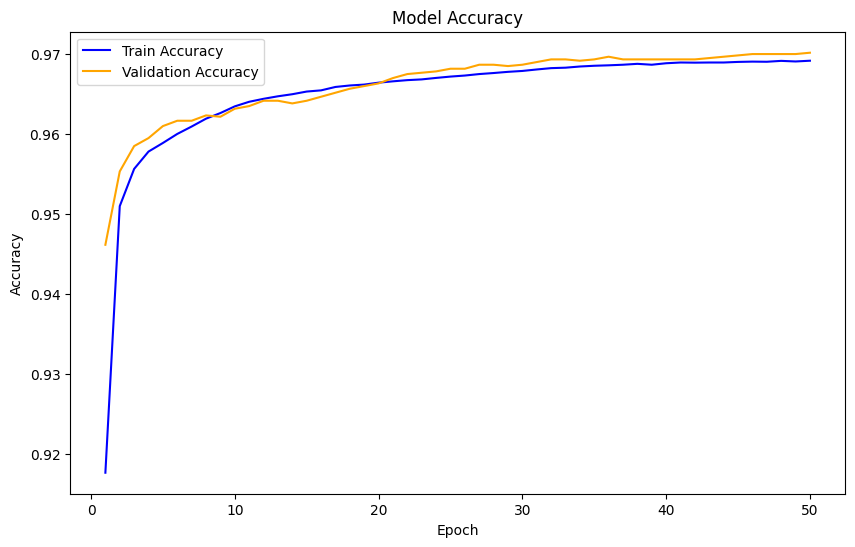

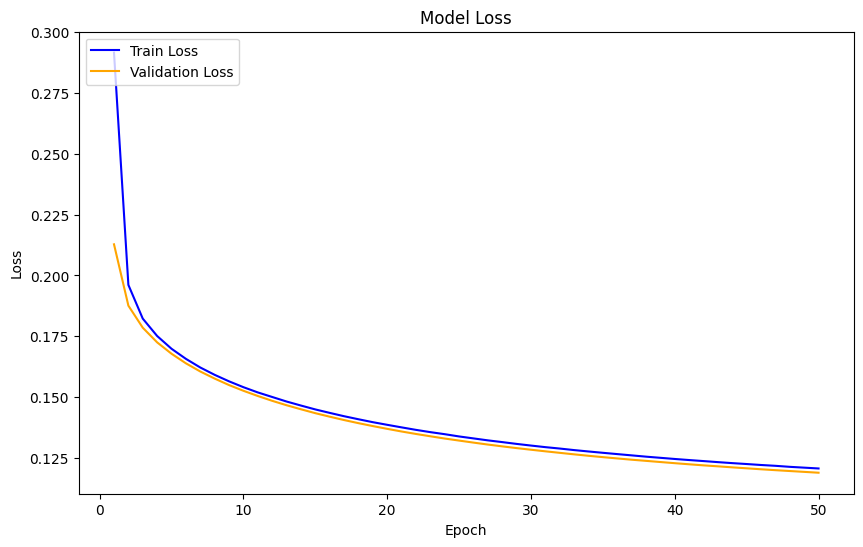

In [14]:
# Display the training statistics
display_stats(training_stats_pm1)

####  EVALUATE FINE TUNED PRUNED MODEL 1

In [15]:
# Evaluate model performance on the entire test dataset
test_loss = 0
correct = 0
with torch.no_grad():
    student_m1_prune.eval()
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = student_m1_prune(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()   
# Compute the average loss across all test samples
test_loss /= len(test_dataloader)
# Print evaluation results
print(f'\nPruned Model 1(structured) Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({100. * correct / len(test_dataloader.dataset):.0f}%)\n')


Pruned Model 1(structured) Test set: Average loss: 0.1084, Accuracy: 9732/10000 (97%)



## FINE TUNE MODEL PRUNED 2

In [16]:
criterion_pruned_2 = nn.CrossEntropyLoss()
sgd_pruned_2 = optim.SGD(student_m2_prune.parameters(), lr=learning_rate_m2, momentum=0.0)
trainer_pruned_2 = Trainer(student_m2_prune, device)

In [17]:
# Lists to store the training and validation statistics
train_losses = []
valid_losses = []
train_acc = []
valid_acc = []

# Training loop
for _ in tqdm(range(epochs_m2), desc="Epochs: "):
    # Set model to training mode and reset statistics at the start of each epoch
    student_m2_prune.train()
    trainer_pruned_2.init_params()
    for data_train in train_loader:
        # Perform training steps
        trainer_pruned_2.train_step(data_train, criterion_pruned_2, sgd_pruned_2)
    # Store training stats for this epoch
    train_losses.append(trainer_pruned_2.train_loss / len(train_loader))
    train_acc.append(trainer_pruned_2.train_acc / len(train_loader.dataset))
    with torch.no_grad():
        for data_val in valid_loader:
            # Perform validation steps
            trainer_pruned_2.val_step(data_val, criterion_pruned_2)
        # Store validation stats for this epoch
        valid_losses.append(trainer_pruned_2.val_loss / len(valid_loader))
        valid_acc.append(trainer_pruned_2.val_acc / len(valid_loader.dataset))
print("Training completed.")

Epochs: 100%|██████████| 50/50 [09:53<00:00, 11.87s/it]

Training completed.


In [18]:
# Save training and validation statistics to a file
np.savez("stats/student_model_pruned_2_fine_tuned_stats.npz", train_losses=np.array(train_losses), train_acc=np.array(train_acc), valid_losses=np.array(valid_losses), valid_acc=np.array(valid_acc), allow_pickle=True)
# Save the trained model parameters
torch.save(student_m2_prune.state_dict(), "models/student_model_pruned_2_fine_tuned.pth")
print("Model saved to models/student_model_pruned_2_fine_tuned.pth")

Model saved to models/student_model_pruned_2_fine_tuned.pth


In [19]:
# Define the path to your training statistics
TRAINING_STATS_PM2 = "stats/student_model_pruned_2_fine_tuned_stats.npz"

In [20]:
# Load model training statistics (accuracy and loss)
training_stats_pm2  = np.load(TRAINING_STATS_PM2)

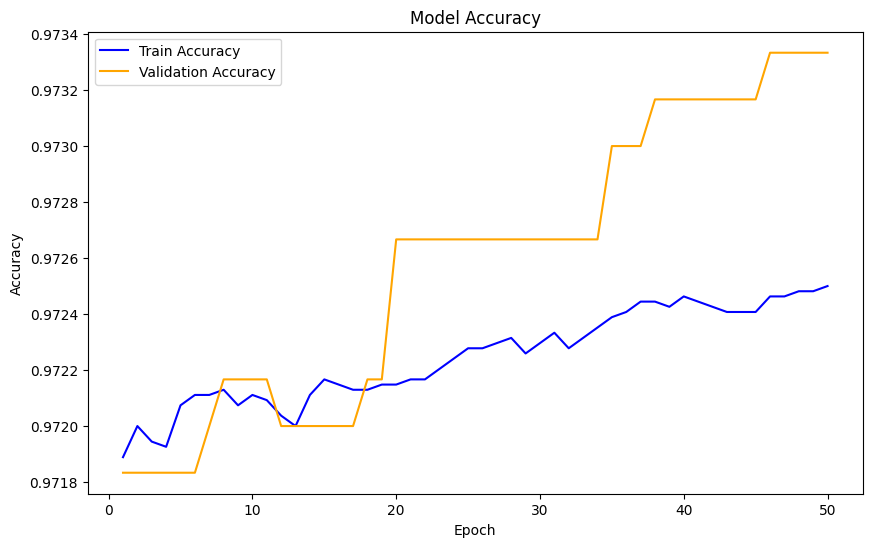

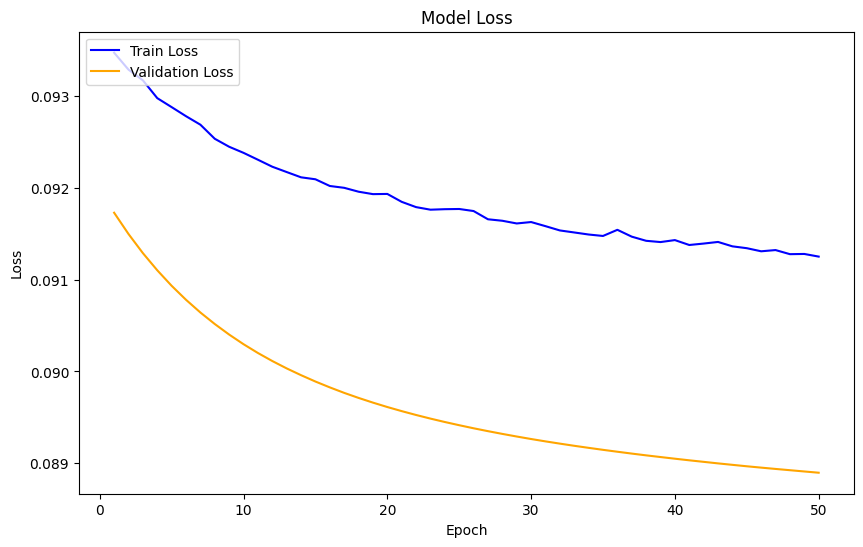

In [21]:
# Display the training statistics
display_stats(training_stats_pm2)

####  EVALUATE FINE TUNED PRUNED MODEL 2

In [22]:
# Evaluate model performance on the entire test dataset
test_loss = 0
correct = 0
with torch.no_grad():
    student_m2_prune.eval()
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = student_m2_prune(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()   
# Compute the average loss across all test samples
test_loss /= len(test_dataloader)
# Print evaluation results
print(f'\nPruned Model 2(unstructured) Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({100. * correct / len(test_dataloader.dataset):.0f}%)\n')


Pruned Model 2(unstructured) Test set: Average loss: 0.0798, Accuracy: 9757/10000 (98%)

